In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.sde_learning_network_modified import (
    TimingCallback,
    SDEIdentification,
    ModelBuilder,
    SDEApproximationNetwork,
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data
)

%load_ext autoreload
%autoreload 2

2025-06-16 07:22:20.119501: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 07:22:20.124163: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-06-16 07:22:20.124179: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# notebook parameters
n_dimensions = 1
step_size = 1e-2
n_pts = 10000
n_subsample = 1000

random_seed = 1


In [3]:
# network parameters
n_layers = 2
n_dim_per_layer = 2**6

ACTIVATIONS = tf.nn.elu
# def ACTIVATIONS(x):
#     j = tf.constant(1j, dtype=tf.complex64)
#     x = tf.cast(x, dtype=tf.complex64)
#     return tf.exp(j * x)
VALIDATION_SPLIT = .1
BATCH_SIZE = 2**5
LEARNING_RATE = 1e-3
N_EPOCHS = 100

diffusivity_type = "diagonal"

In [4]:
# generate training data
def true_drift(x):
    result = -(4 * x**3 - 8 * x + 3) / 2
    return result.reshape(-1, 1)


def true_diffusion(x):
    result = (0.1 * x + 1) * 0.5
    return result.reshape(-1, 1)


def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)


xlim = np.array([[-2, 2]])

step_sizes = np.zeros((n_pts, 1)) + step_size


In [8]:
# train model
No_of_tests = 10
cumulative_times = np.zeros((No_of_tests, N_EPOCHS))
losses = np.zeros((No_of_tests, N_EPOCHS))
val_losses = np.zeros((No_of_tests, N_EPOCHS))
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    rng = np.random.default_rng(random_seed+i)
    tf.random.set_seed(random_seed+i)

    # generate data
    x_data, y_data, _ = sample_data(true_drift_diffusion, step_size, n_pts, n_subsample, rng, xlim)

    # build network
    encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
    model = SDEApproximationNetwork(sde_model=encoder, method="euler")
    model.compile(optimizer=tf.keras.optimizers.Adamax(LEARNING_RATE))
    sde_i = SDEIdentification(model=model)
    timing_callback = TimingCallback()

    # train network
    hist, _ = sde_i.train_model(x_data, y_data, step_size=step_sizes, validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[timing_callback])
    
    cumulative_times[i,:] = timing_callback.epoch_times
    losses[i,:] = hist.history["loss"]
    val_losses[i,:] = hist.history["val_loss"]

    moving_avg = np.zeros(N_EPOCHS)
    min_moving_avg = float('inf')
    moving_avg_len = 5
    min_index = 0
    break_iterations = 5
    for j in range(N_EPOCHS):
        if j < moving_avg_len:
            moving_avg[j] = np.mean(val_losses[i,:j+1])
        else:
            moving_avg[j] = np.mean(val_losses[i,j-moving_avg_len+1:j+1])

        if moving_avg[j] < min_moving_avg:
            min_moving_avg = moving_avg[j]
            min_index = j

        if min_index + break_iterations < j:
            break

    val_loss_array = val_losses[i,:j]
    val_loss_min_index = np.argmin(val_loss_array)
    training_time[i] = cumulative_times[i,val_loss_min_index]
    val_loss[i] = val_losses[i,val_loss_min_index]


training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000
training for 100 epochs with 9000 data points, validating with 1000


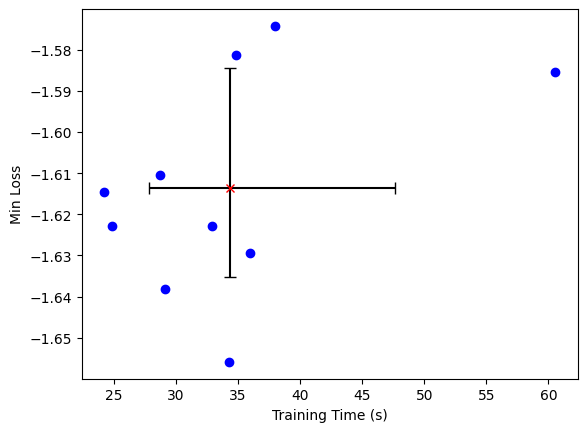

Mean Min Loss:  -1.6134930763253237
Mean Training Time:  34.353647351264954


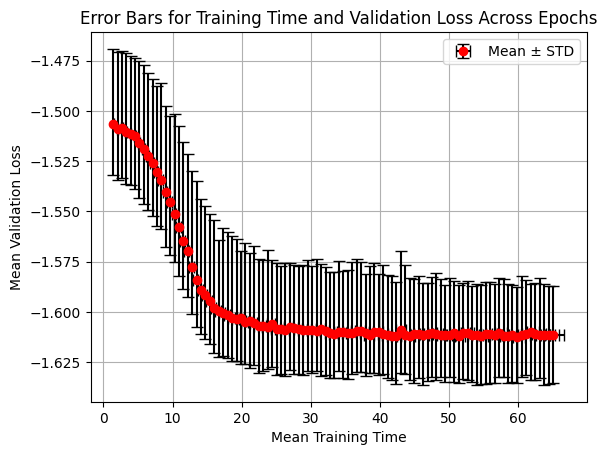

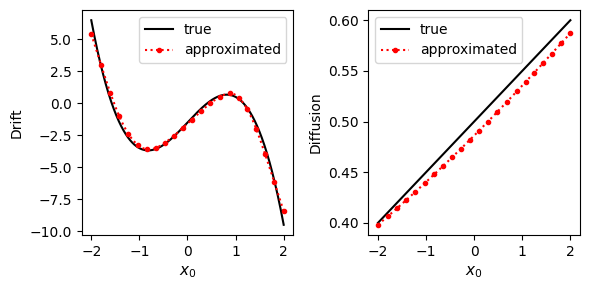

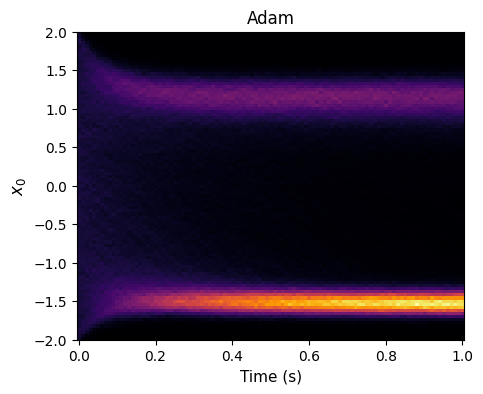

In [9]:
# display and save plots
filename = "example3-1d_sde-cubic_deep"
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=True)
    
PR.loss_v_time(cumulative_times, val_losses, save=True)

PR.plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusion, x_data, save=True)

time = 100*step_size
PR.plot_histogram(sde_i.drift_diffusivity, step_size, time, rng, xlim, name='Adam', save=True)


In [44]:
encoder.summary()

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 128)          256         ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 128)          256         ['GP_inputs[0][0]']              
                                                                                                  
 GP_output_mean (Dense)         (None, 1)            129         ['GP_mean_hidden_0[0][0]']       
                                                                                